In [54]:
import pandas as pd
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.stats.proportion import proportions_ztest, confint_proportions_2indep, proportion_confint
from statsmodels.stats.weightstats import ttest_ind

**Предобработка данных**

In [8]:
df = pd.read_csv('marketing_AB.csv').drop(columns='Unnamed: 0')
df.head()

,user id,test group,converted,total ads,most ads day,most ads hour
0,1069124,ad,False,130,Monday,20
1,1119715,ad,False,93,Tuesday,22
2,1144181,ad,False,21,Tuesday,18
3,1435133,ad,False,355,Tuesday,10
4,1015700,ad,False,276,Friday,14


In [ ]:
#Пропусков нет, типы данных корректны
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 588101 entries, 0 to 588100
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   user id        588101 non-null  int64 
 1   test group     588101 non-null  object
 2   converted      588101 non-null  bool  
 3   total ads      588101 non-null  int64 
 4   most ads day   588101 non-null  object
 5   most ads hour  588101 non-null  int64 
dtypes: bool(1), int64(3), object(2)
memory usage: 23.0+ MB


In [ ]:
#Каждый пользователь встречается только 1 раз
df['user id'].value_counts(ascending=False)

user id
1069124    1
1116707    1
1275145    1
1338348    1
1352590    1
          ..
1381349    1
1526572    1
1144916    1
1321771    1
1237779    1
Name: count, Length: 588101, dtype: int64

**Первичный анализ результатов A/B-тестирования**

In [39]:
control = df[df['test group'] == 'psa']
test = df[df['test group'] == 'ad']

# Расчет вспомогательных показателей
print("Количество пользователей в группах:")
print(f"Контрольная группа (PSA): {len(control)}")
print(f"Тестовая группа (AD): {len(test)}")

print("\nСуммарное количество покупок в группах:")
print(f"Контрольная группа (PSA): {control['converted'].sum()}")
print(f"Тестовая группа (AD): {test['converted'].sum()}")

print("\nКлючевые показатели:")
print(f"Конверсия в контрольной группе: {round(control['converted'].mean()*100, 2)}%")
print(f"Конверсия в тестовой группе: {round(test['converted'].mean()*100, 2)}%")
print(f"Среднее количество рекламы в контрольной группе: {round(control['total ads'].mean(), 2)}")
print(f"Среднее количество рекламы в тестовой группе: {round(test['total ads'].mean(), 2)}")

Количество пользователей в группах:
Контрольная группа (PSA): 23524
Тестовая группа (AD): 564577

Суммарное количество покупок в группах:
Контрольная группа (PSA): 420
Тестовая группа (AD): 14423

Ключевые показатели:
Конверсия в контрольной группе: 1.79%
Конверсия в тестовой группе: 2.55%
Среднее количество рекламы в контрольной группе: 24.76
Среднее количество рекламы в тестовой группе: 24.82


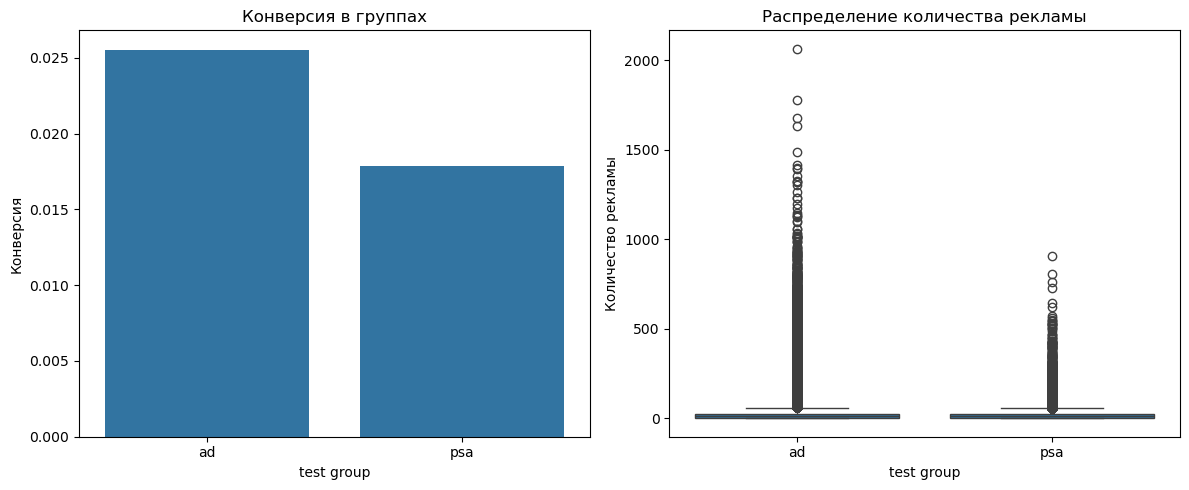

In [ ]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
sns.barplot(x='test group', y='converted', data=df, errorbar=None)
plt.title('Конверсия в группах')
plt.ylabel('Конверсия')

plt.subplot(1, 2, 2)
sns.boxplot(x='test group', y='total ads', data=df)
plt.title('Распределение количества рекламы')
plt.ylabel('Количество рекламы')

plt.tight_layout()
plt.show()

По конверсии можно сделать вывод, что пользователи, видевшие рекламу, чаще совершали покупки, а также принимая во внимание то, что среднее количество просмотренной рекламы в группах почти одинаковое, разница в конверсии объясняется именно просмотром рекламы, что говорит, предварительно, в пользу нашей рекламной компании. Дальнейший стат.тест покажет значимость наблюдаемых различий

**Проведение статистического анализ результатов A/B-тестирования**

***Бизнес-вопросы и соответствующие гипотезы***  
  
**Вопрос 1:**  
"Приводит ли реклама (AD) к увеличению конверсии по сравнению с контрольной группой (PSA)?"

Нулевая гипотеза (H0):  
Конверсия в группе AD не отличается от конверсии в группе PSA  
Альтернативная гипотеза (H1):  
Конверсия в группе AD выше, чем в группе PSA  
Выбор теста:  

Z-тест для односторонней проверки (нам важно именно увеличение конверсии)

**Вопрос 2:**
"Отличается ли среднее количество показов рекламы (total ads) между группами?"

Нулевая гипотеза (H0):  
Среднее количество рекламы в группе AD равно среднему в группе PSA  
Альтернативная гипотеза (H1):  
Среднее количество рекламы в группе AD отличается от группы PSA

Выбор теста:

U-тест Манна-Уитни (непараметрический), так как данные не нормальные (подтвердим это ниже)


In [50]:
#Проверим на нормальность с помощью теста Колмогорова-Смирнова
from scipy.stats import kstest, norm
mean, std = control['total ads'].mean(), control['total ads'].std()
ks_stat, p_value = kstest(control['total ads'], 'norm', args=(mean, std))
print(f"KS-тест (Контрольная группа): p-value={p_value}")
mean, std = test['total ads'].mean(), test['total ads'].std()
ks_stat, p_value = kstest(test['total ads'], 'norm', args=(mean, std))
print(f"KS-тест (Тестовая группа): p-value={p_value}")

KS-тест (Контрольная группа): p-value=0.0
KS-тест (Тестовая группа): p-value=0.0


In [59]:
conversions = [test['converted'].sum(), control['converted'].sum()]
nobs = [len(test), len(control)]

#Доверительный интервал для AD (тестовая группа)
ci_ad = proportion_confint(count=conversions[0], nobs=nobs[0], alpha=0.05, method='wilson')

#Доверительный интервал для PSA (контрольная группа)
ci_psa = proportion_confint(count=conversions[1], nobs=nobs[1], alpha=0.05, method='wilson')

print(f"Конверсия AD: {conversions[0] / nobs[0]} [95% Доверительный интервал: ({ci_ad[0]}, {ci_ad[1]})]")
print(f"Конверсия PSA: {conversions[1] / nobs[1]} [95% Доверительный интервал: ({ci_psa[0]}, {ci_psa[1]})]")

Конверсия AD: 0.025546559636683747 [95% Доверительный интервал: (0.02513821650599992, 0.025961359215123686)]
Конверсия PSA: 0.01785410644448223 [95% Доверительный интервал: (0.016238943989596074, 0.019626711612411318)]


**Доверительные интервалы не перекрываются**

In [ ]:
# Проверка разницы конверсий
zstat, pvalue = proportions_ztest(conversions, nobs)
print(f"Z-тест для конверсий: z={zstat}, p-value={pvalue}")

# Доверительные интервалы для конверсий
ci_control = confint_proportions_2indep(test['converted'].sum(), len(test), 
                                      control['converted'].sum(), len(control), 
                                      compare='diff')
print(f"95% доверительный интервал для разницы конверсий (AD - PSA): ({ci_control[0]}, {ci_control[1]})")

Z-тест для конверсий: z=7.3700781265454145, p-value=1.7052807161559727e-13
95% доверительный интервал для разницы конверсий (AD - PSA): (0.005873422353060636, 0.009360028811460754)


**Вывод по p-value:**  
Поскольку p-value < 0.05, мы отвергаем H0. Тест обнаружил статистически значимые различия между группами. Реклама увеличила конверсию на 0.6–0.9 процентных пунктов с 95% уверенностью

In [36]:
# Так как распределение не нормальное (см.выше), используем непараметрический тест
u_stat, p_value_ads = stats.mannwhitneyu(test['total ads'], control['total ads'])
print(f"U-тест Манна-Уитни для количества рекламы: U={u_stat}, p-value={p_value_ads}")

# Доверительные интервалы для среднего количества рекламы
ads_test = test['total ads'].values
ads_control = control['total ads'].values

# Разница средних
mean_diff = np.mean(ads_test) - np.mean(ads_control)

# Стандартные ошибки
se_test = np.std(ads_test, ddof=1) / np.sqrt(len(ads_test))
se_control = np.std(ads_control, ddof=1) / np.sqrt(len(ads_control))

# Общая стандартная ошибка разницы
se_diff = np.sqrt(se_test**2 + se_control**2)

# Z-критерий для 95% доверительного интервала
z_value = stats.norm.ppf(0.975)  # 1.96 для 95% ДИ

# Границы интервала
lower = mean_diff - z_value * se_diff
upper = mean_diff + z_value * se_diff

print(f"Разница среднего количества рекламы (AD - PSA): {mean_diff}")
print(f"95% доверительный интервал: ({lower}, {upper})")

U-тест Манна-Уитни для количества рекламы: U=6808288222.0, p-value=4.6909108547205694e-11
Разница среднего количества рекламы (AD - PSA): 0.06222754179223955
95% доверительный интервал: (-0.49724707757679376, 0.6217021611612729)


**Вывод по p-value:**  
Поскольку p-value < 0.05, мы отвергаем H0. Тест обнаружил статистически значимые различия между группами, но значение U очень огромно, что можно трактовать как нахождения даже самых крошечных различий, и размер эффекта и доверительный интервал показывают, что это бессмысленно

**Заключение**  
Реклама (AD) успешно увеличила конверсию без влияния на частоту показов. Результаты статистически значимы (p-value около 0, ДИ не перекрываются), разница только в рекламном воздействии

Можно внедрить рекламную стратегию на всей аудитории